In [ ]:
import sys
sys.path.append("/home/twhit/smc_object_detection/")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

import numpy as np
import matplotlib.pyplot as plt

### Load in images

In [2]:
images = torch.load('../data/images.pt').to(device)
true_counts = torch.load('../data/true_counts.pt').to(device)
true_locs = torch.load('../data/true_locs.pt').to(device)
true_fluxes = torch.load('../data/true_fluxes.pt').to(device)

num_counts = true_counts.max().item() + 1  # |{0,1,2,...,max_count}|

In [3]:
image_dim = images.shape[1]
image_index = 1  # choose image with multiple sources just outside the border

grid_interval = image_dim // 4
outer_min = 0 - 0.5
outer_max = image_dim - 0.5
pad = 2

cmap = 'gray'
linewidth = 2
pad_color1 = 'darkorange'
pad_color2 = 'darkorange'

In [4]:
image = images[image_index]
image_height = image.shape[0]
image_width = image.shape[1]

true_counts = true_counts[image_index]
true_locs = true_locs[image_index]
true_fluxes = true_fluxes[image_index]

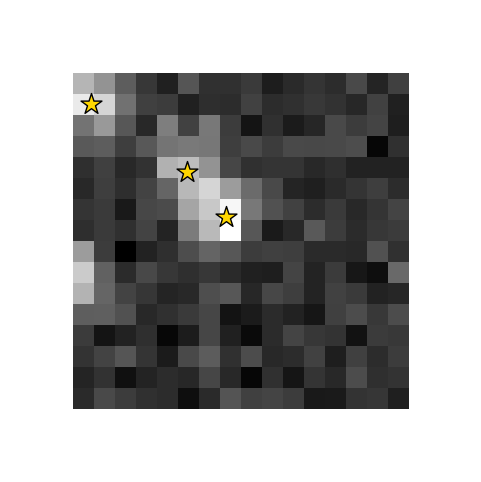

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(true_locs.cpu()[:true_counts.cpu().item(), 1] - 0.5,
               true_locs.cpu()[:true_counts.cpu().item(), 0] - 0.5,
               color = 'gold', edgecolors = 'black', marker = '*', s = 250)
_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = 'white', linewidth = linewidth, alpha = 0)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = 'white', linewidth = linewidth, alpha = 0)

# fig.savefig('figures/image16x16_original.png', dpi = 250, transparent = True)

### Run sampler

In [6]:
prior = StarPrior(max_objects = 10,
                  image_height = image_height,
                  image_width = image_width,
                  flux_mean = 1300,
                  flux_stdev = 250,
                  pad = 2)

imagemodel = ImageModel(image_height = image_height,
                        image_width = image_width,
                        psf_stdev = 1.0,
                        background = 300)

mh = MetropolisHastings(num_iters = 50,
                        locs_stdev = 0.1,
                        fluxes_stdev = 100,
                        fluxes_min = 1300 - 2.5 * 250,
                        fluxes_max = 1300 + 2.5 * 250)

In [7]:
torch.manual_seed(0)

print(f"true count = {true_counts}")
print(f"true total flux = {true_fluxes.sum()}\n")

sampler = SMCsampler(image=images[image_index],
                     tile_dim=image_height,
                     Prior=prior,
                     ImageModel=imagemodel,
                     MutationKernel=mh,
                     num_catalogs_per_count=1000,
                     ess_threshold=800,
                     resample_method="multinomial",
                     max_smc_iters=100)

sampler.run()

true count = 3
true total flux = 3871.13330078125

starting the tile samplers...
iteration 5, temperature = 0.008334051817655563
iteration 10, temperature = 0.02281000092625618
iteration 15, temperature = 0.049997925758361816
iteration 20, temperature = 0.10211258381605148
iteration 25, temperature = 0.24298201501369476
iteration 30, temperature = 0.570087730884552
done!



In [8]:
catalog_index = sampler.weights_intercount.argmax().item()
locs = sampler.locs.squeeze()[catalog_index]
counts = sampler.counts.squeeze()[catalog_index].int()

In [9]:
# distinguish detections in the padding
in_bounds = torch.all(
    torch.logical_and(locs > 0,
                      locs < torch.tensor((image_dim, image_dim))),
    dim = -1
)

in_pad = torch.any(
    torch.logical_or(locs < 0,
                      locs > torch.tensor((image_dim, image_dim))),
    dim = -1
)

count_in_bounds = in_bounds.sum(-1)
locs_in_bounds = in_bounds.unsqueeze(-1) * locs
locs_mask = (locs_in_bounds != 0).int()
locs_index = torch.sort(locs_mask, dim = 0, descending = True)[1]
locs_in_bounds = torch.gather(locs_in_bounds, dim = 0, index = locs_index)

count_in_pad = (in_pad).sum(-1)
locs_in_pad = (in_pad).unsqueeze(-1) * locs
locs_mask = (locs_in_pad != 0).int()
locs_index = torch.sort(locs_mask, dim = 0, descending = True)[1]
locs_in_pad = torch.gather(locs_in_pad, dim = 0, index = locs_index)

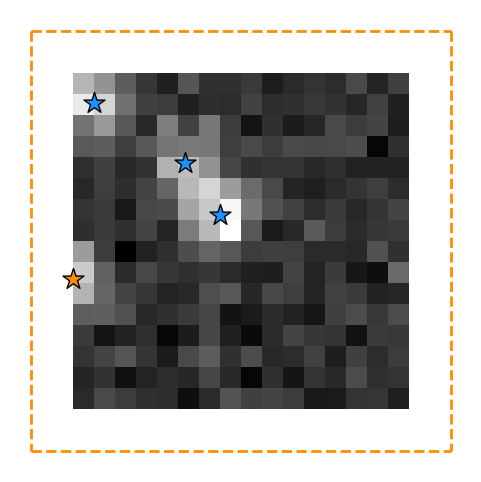

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(locs_in_bounds.cpu()[:count_in_bounds.cpu().item(), 1] - 0.5,
               locs_in_bounds.cpu()[:count_in_bounds.cpu().item(), 0] - 0.5,
               color = 'dodgerblue', edgecolors = 'black', marker = '*', s = 250)
_ = ax.scatter(locs_in_pad.cpu()[:count_in_pad.cpu().item(), 1] - 0.5,
               locs_in_pad.cpu()[:count_in_pad.cpu().item(), 0] - 0.5,
               color = pad_color1, edgecolors = 'black', marker = '*', s = 250)

_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = pad_color1, linestyles = 'dashed', linewidth = linewidth)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = pad_color1, linestyles = 'dashed', linewidth = linewidth)

# fig.savefig('figures/image16x16_detections_padded.png', dpi = 250, transparent = True)

In [11]:
torch.manual_seed(0)

aggmh = MetropolisHastings(
    num_iters=10,
    locs_stdev=0.01,
    fluxes_stdev=5,
    fluxes_min=1300 - 2.5 * 250,
    fluxes_max=1300 + 2.5 * 250,
)

agg = Aggregate(sampler.Prior,
                sampler.ImageModel,
                aggmh,
                sampler.tiled_image,
                sampler.counts,
                sampler.locs,
                sampler.fluxes,
                sampler.weights_intercount,
                resample_method="multinomial",
                merge_method="lw_mixture",
                merge_multiplier=2,
                ess_threshold=(sampler.Prior.max_objects + 1) * sampler.ess_threshold)

agg.run()

aggregating tile catalogs...
done!



In [12]:
unique, num = agg.fluxes.squeeze().unique(dim = 0, return_counts = True)
catalog_index = (agg.fluxes.squeeze() == unique[num.argmax()]).all(dim = 1).nonzero()[0].item()
locs = agg.locs.squeeze()[catalog_index]
counts = agg.counts.squeeze()[catalog_index]

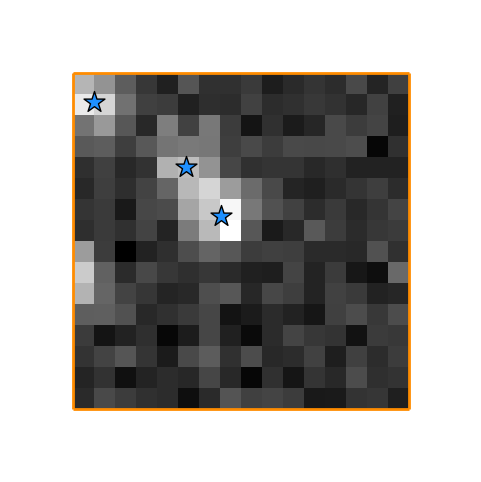

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = ax.scatter(locs.cpu()[:counts.cpu().item(), 1] - 0.5,
               locs.cpu()[:counts.cpu().item(), 0] - 0.5,
               color = 'dodgerblue', edgecolors = 'black', marker = '*', s = 250)

_ = ax.vlines(x = [outer_min - pad, outer_max + pad],
              ymin = outer_min - pad, ymax = outer_max + pad,
              color = 'white', linewidth = linewidth, alpha = 0)
_ = ax.hlines(y = [outer_min - pad, outer_max + pad],
              xmin = outer_min - pad, xmax = outer_max + pad,
              color = 'white', linewidth = linewidth, alpha = 0)
_ = ax.vlines(x = [outer_min, outer_max],
              ymin = outer_min, ymax = outer_max,
              color = pad_color1, linewidth = linewidth)
_ = ax.hlines(y = [outer_min, outer_max],
              xmin = outer_min, xmax = outer_max,
              color = pad_color1, linewidth = linewidth)

# fig.savefig('figures/image16x16_detections.png', dpi = 250, transparent = True)